## final project submission

Please fill out:
* Student name: Claire Sarraille
* Student pace: self paced
* Scheduled project review date/time: Fri, Feb 11, 2022, 02:00 PM - 02:45 PM
* Instructor name: Matt Carr
* Blog post URL: https://clairesarraille.github.io/2021/08/08/kings_county_housing.html


In [84]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline


## CRISP-DM -- CRoss Industry Standard Process for Data Mining
- Following this process ensures that the requirements and organization of formal hypothesis testing are met (broadly speaking, an iterative approach to modeling)
- Not every step was necessary, or was in scope for this particular exercise. 
----------
- Business Understanding
    - Who will be  using the model
    - How will the model be used
    - How will using the model help our business
    - clarify requirements
    - What problems are in and out of scope

- Understand Data
    - What is target
    - What are predictors
    - Distribution of Data
    - How many observations - and is this a small, medium or large collection?
    - What is the quality? - What errors could be in the data, or inaccuracy?

- Data Preparation - Prepping to model
    - Missing values
    - Type conversions
    - Remove multicollinearity (correlated predictors)
    - Standardize numeric data
    - Convert categorical data to numeric via one-hot encoding

- Modeling:
    - Tune models to get the highest performance possible on our task
    - Considerations:
        - What kind of task? Classification task? Regression task?
        - Which models will we use
        - Will we use regularization?
        - How will we validate our model?
        - Loss functions?
        - What is the performance threshold for success?

- Evaluation:
    - Does the model solve business problem outlined in step 1?
    - At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
    - Things we may learn at this stage:
        - Need different data
        - Need more data
        - Should be going in a different direction
        - Should use classificaion rather than regression, or vice versa
        - Use different approach

- Deployment:
    - Move the model into production
    - Set up ETL - how much of preprocessing and cleaning can be automated?


# BUSINESS UNDERSTANDING
- Who will be  using the model?
    - The hypothetical real estate agency I work for
    - Our clients are typically people trying to sell their family home - this business case is not for apartment buildings or hotel real estate
- How will the model be used?
    - It will help us understand which variables (number of bedrooms, square footage) contribute the most to a positive increase in home selling price
- How will using the model help our business?
    - It will provide the evidence we need to give data-driven advice to our clients
    - Helping our clients make decisions to maximize selling price will increase our commissions 
    - We also have the option of charging our clients for a home-renovation consultation which would include access to the data from our model
- Clarify Requirements:
    - Coefficients for each independent variable: these coefficients represent the dollar amount impact on selling price associated with a one-unit increase of a given variable.
- What problems are in and out of scope?
    - In scope: How do home renovations impact the selling price of a home.
    - Out of scope: What selling price the model would predict given new data (data we haven't seen yet) 

# UNDERSTAND DATA
- What is **target**
>'price'
- What are **predictors**
>'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built'
- Distribution of Data - See section "DISTRIBUTIONS" 
- How many observations - and is this a small, medium or large collection?
    - 21,597 entries
    - According to Frank Harrell in his book Regression Modeling Strategies, you need at least 10-20 observations per predictor
    - We have many, many more observations than 20 * (6 - num covariates) = 120
    - Our dataset would be considered large
- What is the quality? - What errors could be in the data, or inaccuracy? - See section "Data Quality" 

## Read in Data

In [87]:
df = pd.read_csv('data/kc_house_data.csv')

## Remove Features
- date (no explanatory value)
- view ( has been viewed, this wouldn't help us predict prices) 
- Note: **sqft_above + sqft_basement = sqft_living**, according to meta-data:
    - sqft_above (is redundant -- repeats sqft_living)
    - sqft_basement (is redundant -- repeats sqft_living)
- yr_renovated (doesn't add very much information we don't already have by including yr_built, grade, and condition) 
- Not helpful to have geographic features becuase we're not realistically expecting home owners to re-locate a home as part of their renovations 
    - zipcode
    - lat
    - long
- sqft_living15 (is redundant - repeats sqft_living)
- sqft_lot15 (is redundant - repeats sqft_lot)

In [88]:
# Why reduce features?
# I narrowed my list of features to avoid over-fit of the training dataset
# Reducing redundancy in features increases the accuracy of the model
# Note: The brief for this project also recommended dropping these features.

df = df.drop(['date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [89]:
# Note: sqft_living includes a finished basement, if present
# Grade is the construction quality of improvements, according to a King County grading system
# Condition is overall condition of house
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

## Data Quality

- There could be outliers - such as hundreds of bathrooms -- this wouldn't make sense considering a given home's square-footage 
- Year could be in the future
- price could be a negative number
- datatype could be wrong - such as string for number of bedrooms

### Waterfront Missing Values

In [90]:
# Waterfront is our only variable containing NULL values:
df.isnull().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

- I filled in NaN values for 'waterfront' with 0. Now, 'waterfront' has a 1 value if there is a view, and 0 value if there is not.
- I also cast this column as an integer type since there are no other options besides the integers 1 and 0.

In [91]:
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'] = df['waterfront'].astype(int)
df['waterfront'].unique()

array([0, 1])

## Cast Features -- at a Different Scale for Visualization 

In [92]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560

In [93]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [94]:
df[['price_millions','price', 'acres_lot']]

,price_millions,price,acres_lot
0,0.221900,221900.0,0.129706
1,0.538000,538000.0,0.166253
2,0.180000,180000.0,0.229568
3,0.604000,604000.0,0.114784
4,0.510000,510000.0,0.185491
...,...,...,...
21592,0.360000,360000.0,0.025964
21593,0.400000,400000.0,0.133448
21594,0.402101,402101.0,0.030992
21595,0.400000,400000.0,0.054821


In [95]:
print(f"The max price is {df['price_millions'].max()} million, min price is {df['price'].min()}")

The max price is 7.7 million, min price is 78000.0


## DISTRIBUTIONS

### Clarify Grade and Condition Columns

#### King County's Grading System for Buildings:
##### Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1. Falls short of minimum building standards. Normally cabin or inferior structure.

2. Falls short of minimum building standards. Normally cabin or inferior structure.

3. Falls short of minimum building standards. Normally cabin or inferior structure.

4. Generally older, low quality construction. Does not meet code.

5. Low construction costs and workmanship. Small, simple design.

6. Lowest grade currently meeting building code. Low quality materials and simple designs.

7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9. Better architectural design with extra interior and exterior design and quality.

10. Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11. Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13. Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

#### King County's Condition Scale: 
##### Relative to age and grade. Coded 1-5.

1. Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2. Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4. Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5. Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

### Describe Data - Descriptive Statistics

In [96]:
#Markdown Version of Below Table:
#df_markdown = df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']].describe()
#print(df_markdown.to_markdown())

In [99]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'acres_lot': '{:.2f}',  'price': '{:20,.0f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

,price,bedrooms,bathrooms,sqft_living,acres_lot,floors,waterfront,condition,grade,yr_built
count,"21,597",21597.00,21597.00,"21,597.00",21597.00,21597.00,21597.00000,21597.00,21597.00,21597
mean,"540,297",3.37,2.12,"2,080.32",0.35,1.49,0.00676,3.41,7.66,1971
std,"367,368",0.93,0.77,918.11,0.95,0.54,0.08194,0.65,1.17,29
min,"78,000",1.00,0.50,370.00,0.01,1.00,0.00000,1.00,3.00,1900
25%,"322,000",3.00,1.75,"1,430.00",0.12,1.00,0.00000,3.00,7.00,1951
50%,"450,000",3.00,2.25,"1,910.00",0.17,1.50,0.00000,3.00,7.00,1975
75%,"645,000",4.00,2.50,"2,550.00",0.25,2.00,0.00000,4.00,8.00,1997
max,"7,700,000",33.00,8.00,"13,540.00",37.91,3.50,1.00000,5.00,13.00,2015


#### Interpret .describe() 
- There are no negative values for any of the columns
- The year range makes sense: homes were built between 1900 and 2015
- sqft_living average is around 2,000, which is close to the US average
- The average lot size is 15,099 square feet, or .35 acres
- The lot size mean is skewed by our outlier home, which stands on a 37.91 acre lot.
- The median sqft_lot size is 7,618 or .17 acres, which is much closer to the national average of 0.188 of an acre.
- Condition and Grade: The mean, max, and min all line-up with the scale of the system, described above.
    - Mean Grade is 7.66, so between a 7 and 8: 
        - 7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.
        - 8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
    - Mean Condition is 3.41, closest to a 3: 
        - 3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

### Price Frequency Histogram

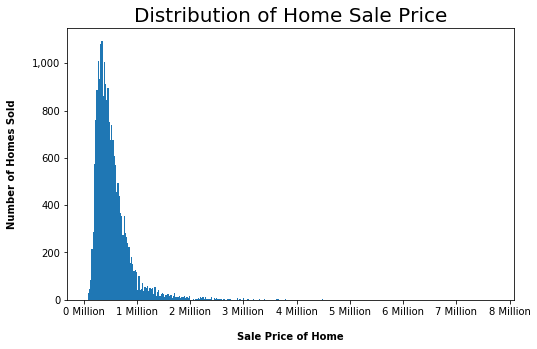

In [98]:
# Price Frequency Histogram before removing outliers, for context:
# Here we can see that the distribution of price, our target variable, has considerable right-skew
ax = df.hist(column='price_millions',
             bins='auto',
             grid=False,
             figsize=(8,5))

ax = ax[0]
for x in ax:

    x.set_title("Distribution of Home Sale Price", size=20)

    # Set x-axis label
    x.set_xlabel("Sale Price of Home", labelpad=15, weight='bold', size=10)
    x.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}' + ' Million'))

    # Set y-axis label
    x.set_ylabel("Number of Homes Sold", labelpad=15, weight='bold', size=10)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


### Price Density Histogram

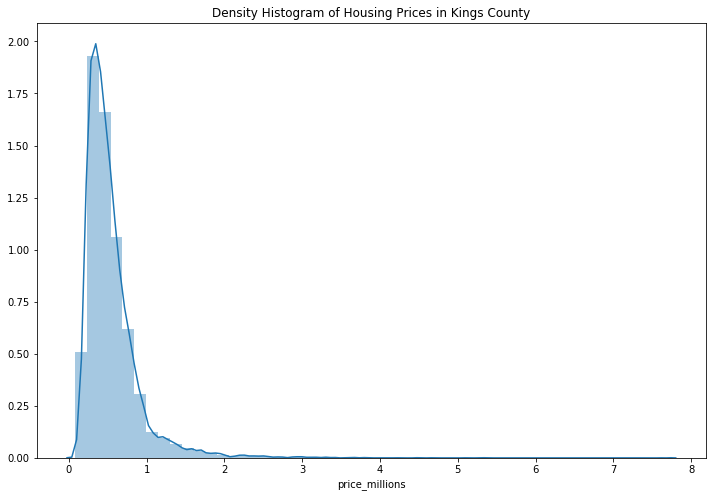

In [28]:
# Ok. Now let's draw a smooth curve, given the above data, using KDE (kernal density estimation)
# The smooth line in the visualization below is an estimate of the distributions of house prices
# The parameter bandwidth rules the smoothness of the underlying distribution

# The problem with a Probability Density Function plot, is that all "point probabilities" are 0
# We must calculate the area under the curve for an interval to get the actual probability that a home selling price is in a given range. 
# Thus, it's not intuitive or easy to "read" the y-axis to get probabilities for continuous variables using a PDF like below.

plt.figure(figsize = (12,8))
sns.distplot(df.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

For example, if we wanted to know the probability that a house price is between 1.00 and 1.75 million dollars (inclusive), we would use the following formula to take the integral of this range (AKA area under the curve)
$$\large P(1 \leq X \leq 1.75) = \int_{1}^{1.75} f_x(x) dx \geq 0 $$


### Narrow dataset for modeling 

In [100]:
# Remember all columns in df are: 
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'acres_lot',
       'price_millions'],
      dtype='object')

In [101]:
# Select a subset of columns to create matrix:
df_all_cols = df.drop(['acres_lot','id'], axis=1)

In [102]:
df_all_cols.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

# DATA PREPARATION
- Prepping to model and addressing missing values -- completed in previous section "Data Quality"
- Convert categorical data to numeric via one-hot encoding (we didn't need to do this because everything is numeric and ordinal)
- Type conversions (this was done in the previous section - price to millions and sqft to acres)
- Remove multicollinearity (correlated predictors)
- Standardize numeric data -- We're not going to standardize our independent variables using z-score normalization because it's not necessary unless we're using logistic regression. 


## Explore Multicollinearity
- This a phenemonen where two variables we are using as predictors are correlated with each other
- This violates one of the assumptions of performing linear regression - that all independent variables are independent from one another
- If we left all features in the model without addressing multicollinearity, it would become very hard for the model to estimate the relationship between independent variables and the dependent variable, because rather than change independently, the features would change in pairs or groups.

In [103]:
correlations = df_all_cols.drop(['price'],axis = 1).corr()

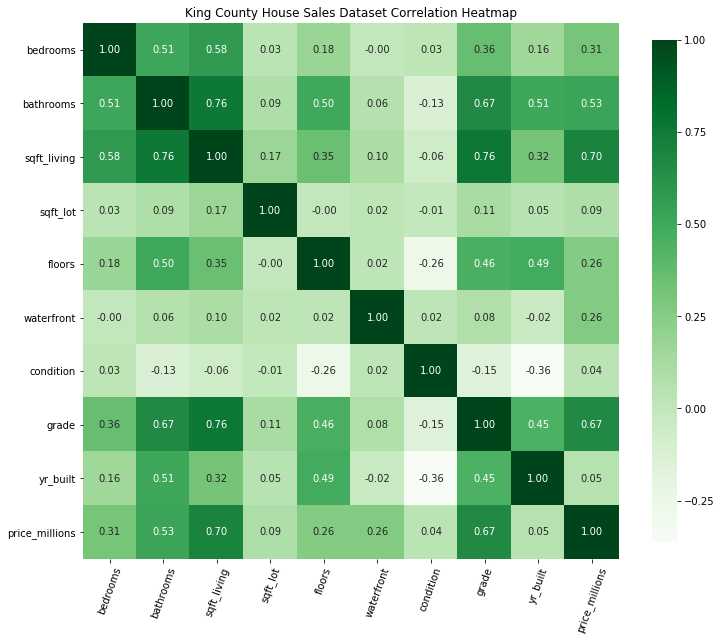

In [104]:
plt.figure(figsize=(12,12)) # Set size of figure
# Use df.corr() as your matrix for the heatmap
# I set the color scheme to green using cmap
# annot= True adds the float value on each square
# fmt='.1f' sets the number of decimal places for each float number. If you want 1.00, for example, use fmt='.2f'
# cbar_kws={"shrink": .77}  - this argument shrinks the side color bar to .77 of its original size
# square=True - this argument makes the figure square
ax = sns.heatmap(correlations, cmap = "Greens", annot=True, fmt='.2f', cbar_kws={"shrink": .77}, square=True)
# Sets the title
ax.set(title='King County House Sales Dataset Correlation Heatmap')
# Get the y-axis limit values for the size of the figure:
bottom, top = ax.get_ylim()
# Add .5 to the bottom and top of the y-axis limits to fix an error where the top and bottom squares are cut off
# This is an error for the versions of Seaborne and Matplotlib I'm using
ax = ax.set_ylim(bottom + 0.5, top - 0.5)
# Rotate the bottom labels by 30 degrees (100-70)
plt.xticks(rotation=70)
plt.show()


In [34]:
correlations['price_millions'].sort_values(ascending=False)

price_millions    1.000000
sqft_living       0.701917
grade             0.667951
bathrooms         0.525906
bedrooms          0.308787
waterfront        0.264306
floors            0.256804
sqft_lot          0.089876
yr_built          0.053953
condition         0.036056
Name: price_millions, dtype: float64

In [35]:
correlations["sqft_living"].sort_values(ascending=False)

sqft_living       1.000000
grade             0.762779
bathrooms         0.755758
price_millions    0.701917
bedrooms          0.578212
floors            0.353953
yr_built          0.318152
sqft_lot          0.173453
waterfront        0.104637
condition        -0.059445
Name: sqft_living, dtype: float64

### Correlations Interpretation 
- Features highly correlated with price are sqft_living, grade, and bathrooms
- Features highly correlated with sqft_living are grade, bathrooms, price_millions, and bedrooms

## Address Multicollinearity
- First, review the columns and shape of the dataframe we will be using -- "df_all_cols"
- Next, use Variance Inflation Factor to detect high multicollinearity in our set of independent variables

In [105]:
df_all_cols.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

In [106]:
df_all_cols.shape

(21597, 11)

In [108]:
# We want to write a simple loop to use statsmodel's variance_inflation_factor method on each array (row) of our dataframe, for each column 
# That's why we use X.shape[1] as the range in the loop below, since the second term in the output of the .shape method is the number of columns
X = sm.add_constant(df_all_cols.drop(['price','price_millions'], axis=1))
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const          7601.443966
bedrooms          1.628887
bathrooms         3.186926
sqft_living       4.152240
sqft_lot          1.047462
floors            1.573844
waterfront        1.021879
condition         1.182857
grade             2.888261
yr_built          1.734538
dtype: float64

### sqft_living has a moderately high VIF value, followed by grade
- We can try removing sqft_living or grade to see if it improves our R-squared and Root Mean Squared Error values.

# df_all_cols - Linear Regression
- Tune models to get the highest performance possible on our task
  - Considerations:
    - What kind of task? Classification task? Regression task?
      - This will be a regression task
    - Which models will we use
      - Linear Regression
    - Will be use regularization?
      - Out of scope for this exercise
    - How will we validate our model?
      - R-squared, Mean Squared Error, and the p-values of each coefficient.
    - Loss functions?
      - Out of scope for this exercise
    - What is the performance threshold for success?
      - We want to make sure to satisfy the assumptions of linear regression, and get a respectable R-squared value (at least .5)


## df_all_cols - statsmodels 
- First we'll use statsmodels.api to run a linear regression and examine model validation scores.
- We'll use all the independent variables (df_all_cols) for now.

In [109]:
df_all_cols.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

In [110]:
# Add constant (AKA y-intercept):
# The constant is set to 1 as default - with means that our constant coefficient will be equal to 1*Beta(0)
# Our other variables (other Betas) will be multiplied by a particular coefficient to predict price
X = sm.add_constant(df_all_cols.drop(['price','price_millions'], axis=1))
y = df_all_cols['price_millions']
X.head()

,const,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,1.0,3,1.00,1180,5650,1.0,0,3,7,1955
1,1.0,3,2.25,2570,7242,2.0,0,3,7,1951
2,1.0,2,1.00,770,10000,1.0,0,3,6,1933
3,1.0,4,3.00,1960,5000,1.0,0,5,7,1965
4,1.0,3,2.00,1680,8080,1.0,0,3,8,1987


In [111]:
# The order of the parameters is: endogenous response variable(dependent variable), exogenous variables(independent variables)
model_all_cols = sm.OLS(y,X).fit()

In [112]:
model_all_cols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     4370.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:16:34   Log-Likelihood:                 2185.7
No. Observations:               21597   AIC:                            -4351.
Df Residuals:                   21587   BIC:                            -4272.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.6950      0.130     51.593      0.000       6.441       6.949
bedrooms       -0.0426      0.002    -20.757      0.000      -0.047      -0.039
bathrooms       0.0508      0.003     14.695      0.000       0.044       0.058
sqft_living     0.0002    3.3e-06     53.646      0.000       0.000       0.000
sqft_lot     -2.43e-07   3.68e-08     -6.605      0.000   -3.15e-07   -1.71e-07
floors          0.0210      0.003      6.069      0.000       0.014       0.028
waterfront      0.7551      0.018     41.124      0.000       0.719       0.791
condition       0.0190      0.002      7.620      0.000       0.014       0.024
grade           0.1301      0.002     60.319      0.000       0.126       0.134
yr_built       -0.0038   6.67e-05    -57.635      0.000      -0.004      -0.004
==============================================================================
Omnibus:                    15869.187   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1011405.789
Skew:                           2.942   Prob(JB):                         0.00
Kurtosis:                      36.005   Cond. No.                     3.84e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [113]:
# In addition to R-Squared, we'll use Root Mean Squared Error to validate our model
# Here, our RMSE value is .047821 (million dollars) -- which heuristically can be thought of...
# ...as the normalized distance between our y values and our y-predicted values
# Thus, for any given prediction we make for a home price, we can expect to be about $47,821 off.
# Our model is failing to account for some important features underlying the data.
yhat = model_all_cols.predict(X)
model_rmse = mean_squared_error(y, yhat)
model_rmse

0.04782134337581508

## df_all_cols - sklearn 

In [114]:
# Divide into test and train data
# Train data is for us to estimate our OLS model
# Test data is to parameterize our model, using that model to predict y values (price)
# If test_size = .3, that means 30% of our data is set aside for the testing data
# And 70% of that data for training

# The parameter "random_state" ensures that if there is skew in our data, our 30-70 split is randomly taking from these groups...
# ...so we can have good proportions of randomly selected data and our 30-70 split has good representation 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)

In [115]:
# Linear Regressor - Ordinary Least Squares regression-type estimate:
# Library used: sklearn.linear_model
lr = LinearRegression(fit_intercept=True)

In [116]:
# Train model based on train dataset:
# Regressing the X's onto the y:
# We're getting a fit here, having used 70% of the data
lr.fit(X_train, y_train)
# coef_list = list(lr.coef_)
# name_list = list(X_train.columns)
print(list(zip(lr.coef_, X_train.columns)))


[(0.0, 'const'), (-0.05127590241064849, 'bedrooms'), (0.05358859821330117, 'bathrooms'), (0.00018224659259546863, 'sqft_living'), (-2.6721880690143437e-07, 'sqft_lot'), (0.01897427187788452, 'floors'), (0.7384002610545074, 'waterfront'), (0.015523561005594141, 'condition'), (0.12797929074492664, 'grade'), (-0.003851573269913127, 'yr_built')]


In [117]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [118]:
# Training Data R-Squared Value:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6418071120403939


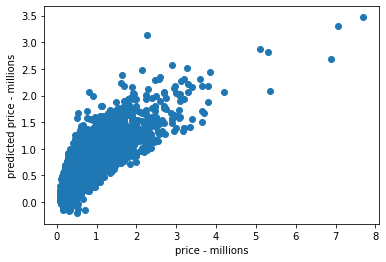

In [119]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

### Interpret price vs. predicted price scatterplot:
- The distribution isn't a straight line, and from that we know that there is something non-linear going on in the relationships we've modeled. 
- Thus, we don't have a good linear relationship between price and our predictors

Text(0, 0.5, 'residuals')

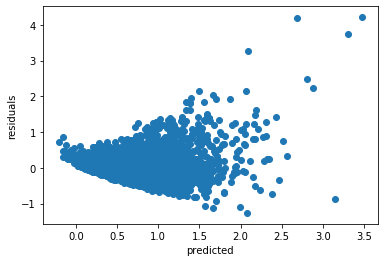

In [120]:
# Predicted Price vs. Residuals
# Inspect the amount of error we got from our OLS Linear Regression:
# The residual is the amount of error in the estimation (difference between predicted and actual y values)

plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

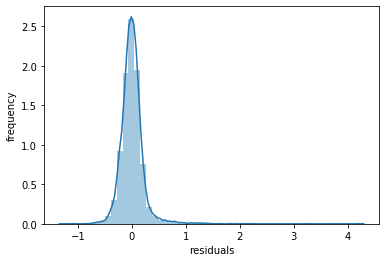

In [121]:
# Check Distribution of Errors:
# We can see from this that there's some right-skew to the distribution of error
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [122]:
# Finally, we take the 30% of that data we set aside for testing, and examine the R-squared value.
# We could take this R-squared value (.653), compare it to the R-squared value we got for the training data (.646), and use them to make assumptions about the fit of our model.
# However, becasue plotting our residuals showed we haven't fulfilled some critical assumptions of linear regression...
# ... we can't really trust these values of R-squared.
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

The R squared value is: 0.6530001064251036


Note:
Ultimately, if our model has a relatively low R-squared value (close to 50%), but we have:
1. fulfilled the assumptions of linear regression 
2. have normally distributed error 
3. coefficients have good p-values

... then we can still draw meaningful conclusions re: the relationships between the independent and dependent variables. Our coefficients will still represent the mean flucuation in the dependent variable for every 1-unit change in a given independent variable. 

## df_all_cols - Interpret
- Using all of our columns to predict price, and not subsetting the data at all:
- Our p-values are all 0.00, which is great.
- However, this model is violating necessary assumptions
    - The scatterplot of predicted price vs. price is clearly not a linear relationship
    - The plot of the residuals vs. the predicted price is trumpet-shaped, which is highly heteroscedastic.
    - What we are aiming for is linearity and homoscedasticity - a fairly even distribution of the residuals vs. predicted price

# Log of Dependent Variable - Linear Regression 

## Log of Dependent Variable - statsmodels
If the distribution of the dependent variable is skewed, and doesn't follow a normal distribution, we can try to predict log(dependent variable) to improve our results.   

In [123]:
## Remember what X and y are:
X = sm.add_constant(df_all_cols.drop(['price','price_millions'], axis=1))
y = df_all_cols['price_millions']

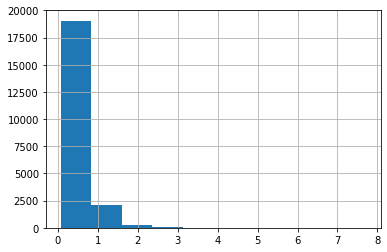

In [124]:
# As we saw in our very first plot, the distribution of price has significant right-skew
y.hist()

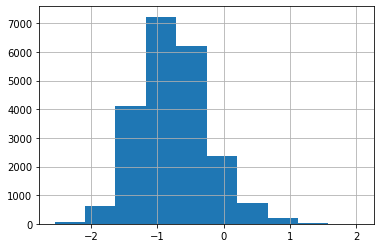

In [125]:
# When we plot the natural logarithm of price, the distribution is now more normally distributed
y_scld = np.log(y)
y_scld.hist();

In [126]:
model_log = sm.OLS(y_scld, X).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     4275.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:20:26   Log-Likelihood:                -5742.5
No. Observations:               21597   AIC:                         1.151e+04
Df Residuals:                   21587   BIC:                         1.158e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.1235      0.187     43.366      0.000       7.756       8.491
bedrooms       -0.0266      0.003     -8.999      0.000      -0.032      -0.021
bathrooms       0.0892      0.005     17.891      0.000       0.079       0.099
sqft_living     0.0002   4.77e-06     36.511      0.000       0.000       0.000
sqft_lot    -6.346e-08   5.31e-08     -1.195      0.232   -1.68e-07    4.06e-08
floors          0.0797      0.005     15.954      0.000       0.070       0.089
waterfront      0.5005      0.027     18.883      0.000       0.449       0.552
condition       0.0433      0.004     12.059      0.000       0.036       0.050
grade           0.2293      0.003     73.661      0.000       0.223       0.235
yr_built       -0.0058   9.63e-05    -59.920      0.000      -0.006      -0.006
==============================================================================
Omnibus:                       97.303   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.897
Skew:                          -0.103   Prob(JB):                     1.12e-25
Kurtosis:                       3.291   Cond. No.                     3.84e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
# For any given prediction we make for a home price, we can expect to be about 1.10 million off. 
yhat = model_log.predict(X)
model_rmse_unscld = np.exp(mean_squared_error(y_scld, yhat))
model_rmse_unscld

1.1047843931961807

## Log of Dependent Variable - sklearn

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_scld, test_size=0.3, random_state=4)

In [129]:
lr.fit(X_train, y_train)
print(list(zip(lr.coef_, X_train.columns)))

[(0.0, 'const'), (-0.035254046296276535, 'bedrooms'), (0.09281188818454528, 'bathrooms'), (0.0001781136721027233, 'sqft_living'), (-1.0506226615530032e-07, 'sqft_lot'), (0.08039950132916493, 'floors'), (0.532223764329006, 'waterfront'), (0.0418658660592447, 'condition'), (0.22696296910017819, 'grade'), (-0.005821955118784636, 'yr_built')]


In [130]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [131]:
# Training Data R-Squared Value:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.638805044310891


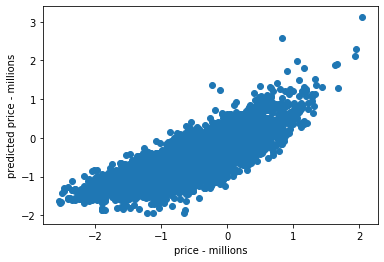

In [132]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

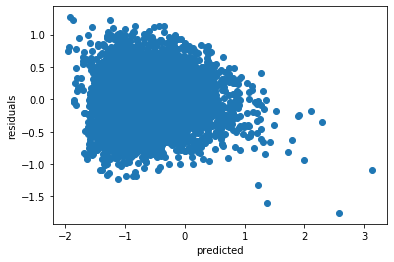

In [133]:
# Predicted Price vs. Residuals
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

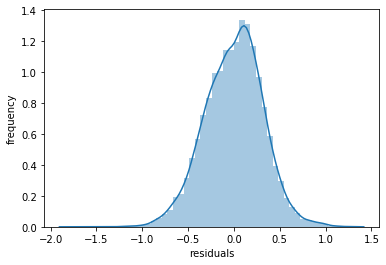

In [134]:
# Check Distribution of Errors:
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [135]:
# R-Squared value for Testing Data:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

The R squared value is: 0.6436848228908654


## Log of Dependent Variable - interpret

- The R-squared value for model_log (0.641) is slightly lower than that of df_all_cols (0.646)
- Our p-values are all 0.00 except for sqft_lot, which is 0.232
- Necessary assumptions for linear regression remain less than ideally fulfilled: 
    - The scatterplot of predicted price vs. price has some non-linearity 
    - The plot of the residuals vs. the predicted price is cone shaped

# Outliers Removed - Linear Regression
- Removing outliers can be a bit of an art, but given that my business case is to offer advice to mostly average, middle-class home owners, it makes sense to eliminate the priciest and lowest cost homes. 
- From the descriptive statistics we ran in the Understanding Data --> Distributions section, I surmised that the independent variables with the most unusual values were price and number of bedrooms. 

## Outliers Removed - statsmodels

In [136]:
df_rm_outliers = df_all_cols.drop(['sqft_lot'], axis=1)

In [137]:
# Here we take the absolute value of the z-scores for each value in columns "price" and "bedrooms" and filter our df by...
# ...only those values which have a z-score < 3

df_rm_outliers = df_rm_outliers[(np.abs(stats.zscore(df_rm_outliers[['bedrooms']])) < 3) & (np.abs(stats.zscore(df_rm_outliers[['price']])) < 3)]

In [138]:
# Sort by Bedrooms:
df_rm_outliers[['price_millions', 'bedrooms', 'bathrooms']].sort_values('bedrooms', ascending = False).head(10)

,price_millions,bedrooms,bathrooms
15120,0.2300,6,1.50
17090,0.3759,6,1.50
7273,0.8000,6,4.25
18641,0.6650,6,3.00
4251,1.3000,6,4.50
9601,0.7600,6,3.75
9604,0.7300,6,2.75
2380,0.4000,6,2.00
2364,0.6650,6,3.00
16540,0.4500,6,2.25


In [139]:
df_rm_outliers.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

In [140]:
#Markdown Version of Below Table:
#df_markdown_rm_outliers = df_rm_outliers[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']].describe()
#print(df_markdown_rm_outliers.to_markdown())

In [141]:
# These values make a lot more sense
# The minimum and maximum values for price, bedrooms, and bathrooms are conceivable attributes of a middle class person's home.
# We didn't sacrifice on the size of our dataset, having only shed only about 4% of the number of rows in the original dataset.
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'price_millions': '{:,.8f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df_rm_outliers[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

,price_millions,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,yr_built
count,"21,139.00000000",21139.00,21139.00,"21,139.00",21139.00,21139.00000,21139.00,21139.00,21139
mean,0.50658452,3.34,2.08,"2,029.04",1.49,0.00378,3.41,7.60,1971
std,0.25931508,0.87,0.73,833.21,0.54,0.06140,0.65,1.11,29
min,0.07800000,1.00,0.50,370.00,1.00,0.00000,1.00,3.00,1900
25%,0.32000000,3.00,1.50,"1,410.00",1.00,0.00000,3.00,7.00,1952
50%,0.44600000,3.00,2.25,"1,890.00",1.00,0.00000,3.00,7.00,1975
75%,0.62605000,4.00,2.50,"2,500.00",2.00,0.00000,4.00,8.00,1996
max,1.64000000,6.00,6.50,"7,350.00",3.50,1.00000,5.00,12.00,2015


In [142]:
# For our other variables (other Betas) will be multiplied by a particular coefficient to predict price
X = sm.add_constant(df_rm_outliers.drop(['price','price_millions'], axis=1))
y = df_rm_outliers['price_millions']
X.head()

,const,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,yr_built
0,1.0,3,1.00,1180,1.0,0,3,7,1955
1,1.0,3,2.25,2570,2.0,0,3,7,1951
2,1.0,2,1.00,770,1.0,0,3,6,1933
3,1.0,4,3.00,1960,1.0,0,5,7,1965
4,1.0,3,2.00,1680,1.0,0,3,8,1987


In [143]:
model_rm_outliers = sm.OLS(y, X).fit() 

In [144]:
model_rm_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     4246.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        13:22:50   Log-Likelihood:                 8666.8
No. Observations:               21139   AIC:                        -1.732e+04
Df Residuals:                   21130   BIC:                        -1.724e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.5885      0.098     57.193      0.000       5.397       5.780
bedrooms       -0.0238      0.002    -14.456      0.000      -0.027      -0.021
bathrooms       0.0388      0.003     14.817      0.000       0.034       0.044
sqft_living     0.0001   2.56e-06     43.338      0.000       0.000       0.000
floors          0.0345      0.003     13.381      0.000       0.029       0.040
waterfront      0.3013      0.018     16.695      0.000       0.266       0.337
condition       0.0194      0.002     10.496      0.000       0.016       0.023
grade           0.1198      0.002     73.457      0.000       0.117       0.123
yr_built       -0.0032   5.03e-05    -63.873      0.000      -0.003      -0.003
==============================================================================
Omnibus:                     3269.379   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9100.564
Skew:                           0.837   Prob(JB):                         0.00
Kurtosis:                       5.744   Cond. No.                     2.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
# For any given prediction we make for a home price, we can expect to be about $25,790 off. 
yhat = model_rm_outliers.predict(X)
model_rmse = mean_squared_error(y,yhat)
model_rmse

0.025787552371068608

## Outliers Removed  - sklearn

In [147]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)

In [148]:
lr.fit(X_train, y_train)
print(list(zip(lr.coef_, X_train.columns)))

[(0.0, 'const'), (-0.023120726261630947, 'bedrooms'), (0.03776946676406125, 'bathrooms'), (0.00011080880224360217, 'sqft_living'), (0.0392415583862586, 'floors'), (0.32900561873079553, 'waterfront'), (0.020165302181521724, 'condition'), (0.11935691598337234, 'grade'), (-0.0032180766803797506, 'yr_built')]


In [149]:
predict_y_train = lr.predict(X_train)

In [150]:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6180374222444134


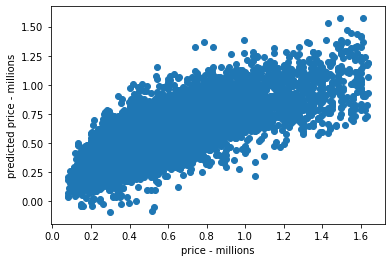

In [151]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

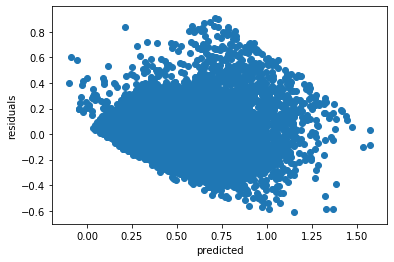

In [152]:
# Predicted Price vs. Residuals
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

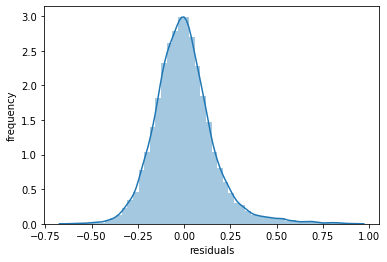

In [153]:
# Check Distribution of Errors:
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [154]:
# R-Squared value for Testing Data:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

The R squared value is: 0.6124112999508387


## Outliers Removed  - interpret

- The R-squared value for model_log is 0.62
- Our p-values are all 0.00
- Model RMSE: For any given prediction we make for a home price, we can expect to be about $25,790 off
- Necessary assumptions for linear regression are better fulfilled than our last two iterations of linear regression modeling: 
    - The scatterplot of predicted price vs. price has a mostly linear shape
    - The plot of the residuals vs. the predicted price is almost evenly spread over the horizontal axis

Dropping sqft_lot and removing outliers based on the value of the z-scores for each value in columns "price" and "bedrooms" has improved our results compared to our last two iterations. Based on our p-values, R-squared value, and RMSE, as well as our assumptions of linear regression, we can be reasonably confident that we can interpret our coefficients as giving us the price increase of our home for every unit increase of the variable.
My real estate company can therefore advise clients that they should install a roof deck if it would add a waterfront view, as well as increase the quality of any improvements in their home, using this scale as their guide to quality craftmanship:
9. Better architectural design with extra interior and exterior design and quality.

10. Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11. Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13. Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.
